In [1]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
#import weatherbench2 as wb
#import metpy
import copy
import wrf
import time
#from metpy.units import units
import cartopy.crs as ccrs
print('modules loaded')
import datetime
import glob
import datetime as dt
import seaborn as sns

modules loaded


In [2]:
figpath='/users/mfeldman/figs/'
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
ifs_init='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
dataset='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
#dataset='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
# dataset='gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
# dataset='gs://weatherbench2/datasets/keisler/2020-360x181.zarr'
# dataset='gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr'
mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
#mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/'
model='graphcast_dawn'

In [3]:
year=2020; month=4; day=np.arange(12,14,1); days=day[0]-np.arange(1,10)
#EVENT SELECTION ERA5
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5)
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([year]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([month]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([day]),latitude=slice(50,20),longitude=slice(250,300))
zsurf_c=xr_era5['geopotential_at_surface']
init=xr_era5.time[0].dt.strftime('%Y%m%d%H').values; print(init)
plevel=copy.deepcopy(xr_era5.level.values)
        
xr_era5['pressure'] = (('level'), plevel)
plevel=xr_era5.pressure
xr_dataset = xr_era5.assign_coords(level=np.arange(len(plevel)))
tlevel=xr_era5.temperature
qlevel=xr_era5.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_era5.geopotential
ulevel=xr_era5.u_component_of_wind
vlevel=xr_era5.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim
psurf=xr_era5.mean_sea_level_pressure
tsurf=xr_era5['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)

ps_era=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

2020041200


In [33]:
era_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps_era, ter_follow=False)
era_inst=era_inst.assign_coords(longitude=psurf.longitude.values);
era_inst=era_inst.assign_coords(latitude=psurf.latitude.values);
era_inst=era_inst.assign_coords(time=psurf.time.values)

In [74]:
# u_l=ulevel.fillna(0)
# v_l=vlevel.fillna(0)
# z_l=zl.fillna(0)
# z_s=zs.fillna(0)
# era_srh_03=wrf.srhel(u=u_l, v=v_l, height=z_l, terrain=z_s, top=3000.0)
# era_srh_06=wrf.srhel(u=u_l, v=v_l, height=z_l, terrain=z_s, top=6000.0)

In [38]:
du_01=ulevel.sel(level=850)-xr_era5['10m_u_component_of_wind']; dv_01=vlevel.sel(level=850)-xr_era5['10m_v_component_of_wind']
du_03=ulevel.sel(level=700)-xr_era5['10m_u_component_of_wind']; dv_03=vlevel.sel(level=700)-xr_era5['10m_v_component_of_wind']
du_06=ulevel.sel(level=500)-xr_era5['10m_u_component_of_wind']; dv_06=vlevel.sel(level=500)-xr_era5['10m_v_component_of_wind']

bs_01=( du_01**2 + dv_01**2 )**0.5
bs_03=( du_03**2 + dv_03**2 )**0.5
bs_06=( du_06**2 + dv_06**2 )**0.5

du_01=du_01.to_dataset(name='du_01')
dv_01=dv_01.to_dataset(name='dv_01')
bs_01=bs_01.to_dataset(name='bs_01')
du_03=du_03.to_dataset(name='du_03')
dv_03=dv_03.to_dataset(name='dv_03')
bs_03=bs_03.to_dataset(name='bs_03')
du_06=du_06.to_dataset(name='du_06')
dv_06=dv_06.to_dataset(name='dv_06')
bs_06=bs_06.to_dataset(name='bs_06')

era_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')

era_params['cape']=era_inst.sel(mcape_mcin_lcl_lfc='mcape')
era_params['cin']=era_inst.sel(mcape_mcin_lcl_lfc='mcin')
era_params['lcl']=era_inst.sel(mcape_mcin_lcl_lfc='lcl')
era_params['lfc']=era_inst.sel(mcape_mcin_lcl_lfc='lfc')

era_params.to_netcdf(mlpath+'USA_tor_2020_era.nc')

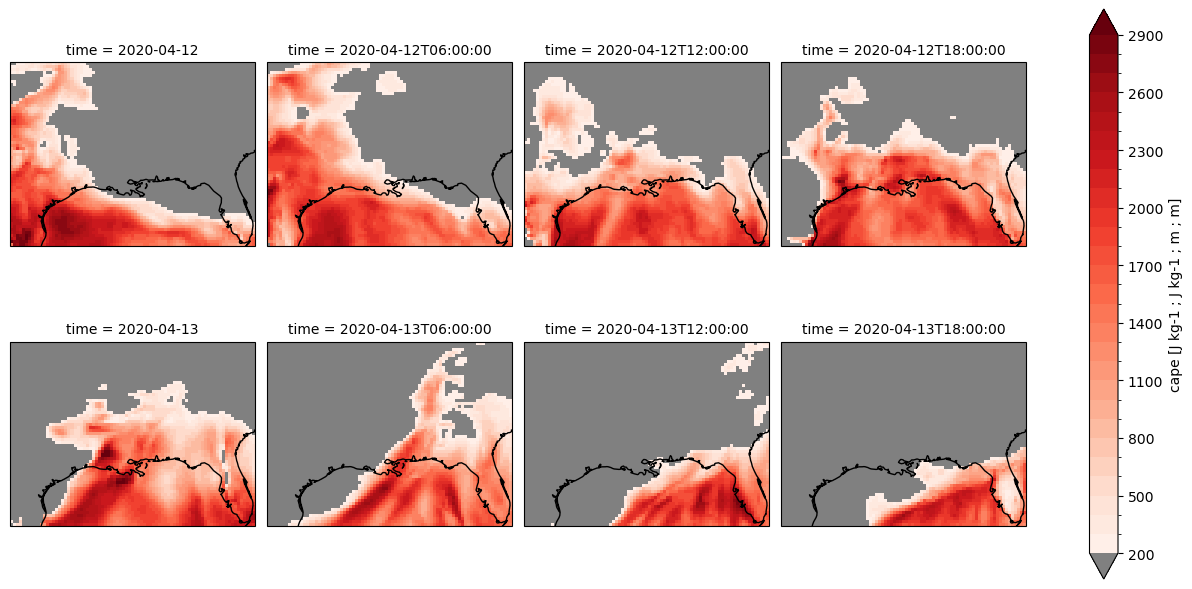

In [73]:
cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
p = era_params.cape.sel(latitude=slice(40,25),longitude=slice(260,280)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=1000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()

In [97]:
ifs_init='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
xr_model=xr.open_zarr(ifs_init)
xr_init=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
xr_init=xr_init.sel(time=xr_init.time.dt.month.isin([month]))#np.arange(3,10)))
xr_init=xr_init.sel(time=xr_init.time.dt.day.isin([day]),latitude=slice(20,50),longitude=slice(250,300))
init=xr_init.time[0].dt.strftime('%Y%m%d%H').values; print(init)
#xr_init=xr_init.sel(prediction_timedelta=xr_init.prediction_timedelta[0])
print(xr_init.dims)
#xr_init=xr_init.squeeze(dim='prediction_timedelta')

xr_init = xr_init.sortby('level', ascending=False)
plevel=copy.deepcopy(xr_init.level.values)
xr_init['pressure'] = (('level'), plevel)
plevel=xr_init.pressure
xr_init = xr_init.assign_coords(level=np.arange(len(plevel)))

tlevel=xr_init.temperature
qlevel=xr_init.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_init.geopotential
ulevel=xr_init.u_component_of_wind
vlevel=xr_init.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim

psurf=xr_init.mean_sea_level_pressure
tsurf=xr_init['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)

ps=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

2020041200
FrozenMappingWarningOnValuesAccess({'time': 8, 'latitude': 121, 'longitude': 201, 'level': 13})


In [98]:
init_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
init_inst=init_inst.assign_coords(longitude=psurf.longitude.values);
init_inst=init_inst.assign_coords(latitude=psurf.latitude.values);
init_inst=init_inst.assign_coords(time=psurf.time.values)

In [99]:
print(xr_init.pressure)

<xarray.DataArray 'pressure' (level: 13)>
array([1000,  925,  850,  700,  600,  500,  400,  300,  250,  200,  150,
        100,   50], dtype=int32)
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12


In [100]:
du_01=ulevel.sel(level=2)-xr_init['10m_u_component_of_wind']; dv_01=vlevel.sel(level=2)-xr_init['10m_v_component_of_wind']
du_03=ulevel.sel(level=3)-xr_init['10m_u_component_of_wind']; dv_03=vlevel.sel(level=3)-xr_init['10m_v_component_of_wind']
du_06=ulevel.sel(level=5)-xr_init['10m_u_component_of_wind']; dv_06=vlevel.sel(level=5)-xr_init['10m_v_component_of_wind']

bs_01=( du_01**2 + dv_01**2 )**0.5
bs_03=( du_03**2 + dv_03**2 )**0.5
bs_06=( du_06**2 + dv_06**2 )**0.5

du_01=du_01.to_dataset(name='du_01')
dv_01=dv_01.to_dataset(name='dv_01')
bs_01=bs_01.to_dataset(name='bs_01')
du_03=du_03.to_dataset(name='du_03')
dv_03=dv_03.to_dataset(name='dv_03')
bs_03=bs_03.to_dataset(name='bs_03')
du_06=du_06.to_dataset(name='du_06')
dv_06=dv_06.to_dataset(name='dv_06')
bs_06=bs_06.to_dataset(name='bs_06')

init_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')

init_params['cape']=init_inst.sel(mcape_mcin_lcl_lfc='mcape')
init_params['cin']=init_inst.sel(mcape_mcin_lcl_lfc='mcin')
init_params['lcl']=init_inst.sel(mcape_mcin_lcl_lfc='lcl')
init_params['lfc']=init_inst.sel(mcape_mcin_lcl_lfc='lfc')

init_params.to_netcdf(mlpath+'USA_tor_2020_ifs_init.nc')

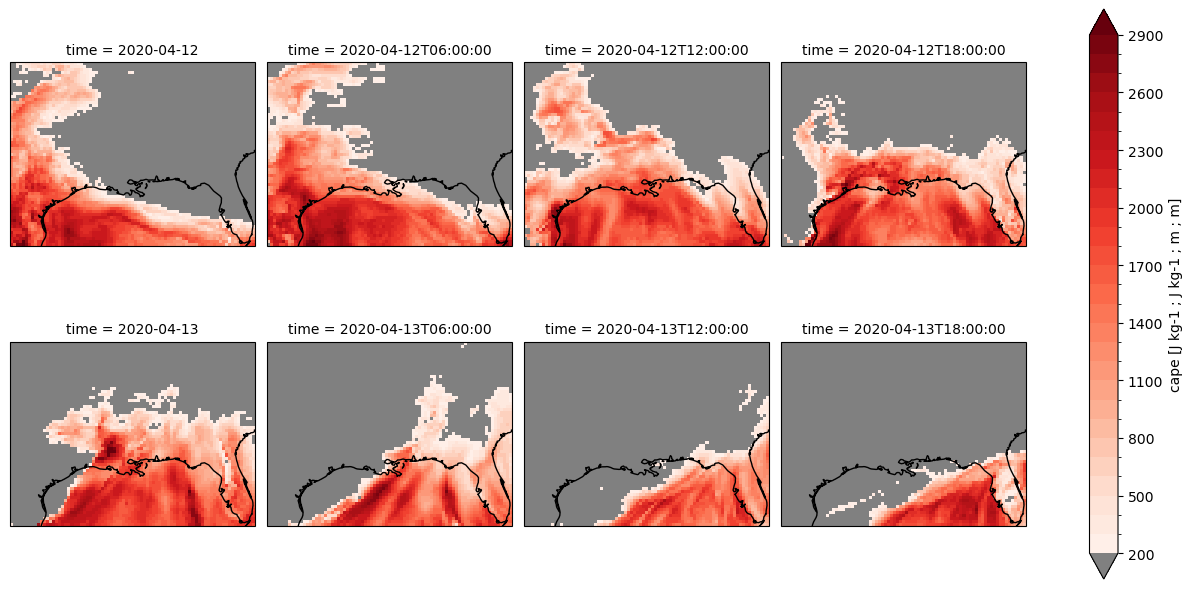

In [101]:
cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
p = init_params.cape.sel(latitude=slice(25,40),longitude=slice(260,280)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=1000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()

In [118]:
start=xr_era5.time[0]
end=xr_era5.time[-1]

#LOADING FORECAST DATASET
models=['pangu','pangu-oper','ifs']
s1=slice(50,20)
s2=slice(20,50)
d1='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
d2='gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
d3='gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d4='gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d5='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
paths=[d1,d2,d5]
slices=[s1,s1,s2]
for nn in range(2,len(models)):
    dataset=paths[nn]
    latslice=slices[nn]
    model=models[nn]
    hours=[0,12]
    for d in days[:]:
        for hour in hours[:]:
            xr_model=xr.open_zarr(dataset)
            xr_dataset=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([month]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([d]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([hour]),latitude=latslice,longitude=slice(250,300))
            fcst_init=xr_dataset.time[0]
            init=fcst_init.dt.strftime('%Y%m%d%H').values; print(init)
            xr_dataset=xr_dataset.sel(prediction_timedelta=slice(start-fcst_init,end-fcst_init))
            xr_dataset = xr_dataset.sortby('level', ascending=False)
            
            plevel=copy.deepcopy(xr_dataset.level.values)
            
            xr_dataset['pressure'] = (('level'), plevel)
            plevel=xr_dataset.pressure
            xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))
            
            tlevel=xr_dataset.temperature
            qlevel=xr_dataset.specific_humidity
            plevel_dim=np.ones([1,len(plevel),1,1])
            zlevel=xr_dataset.geopotential
            ulevel=xr_dataset.u_component_of_wind
            vlevel=xr_dataset.v_component_of_wind
            for n1 in range(len(plevel.data)):
                plevel_dim[0,n1,0,0]=plevel[n1]
            plevel_exp=(tlevel/tlevel)*plevel_dim
            
            psurf=xr_dataset.mean_sea_level_pressure
            tsurf=xr_dataset['2m_temperature']
            zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
            zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
            
            ps=psurf/100
            zs=zsurf/9.81
            zl=zlevel/9.81
    
            mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
            mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
            mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
            mod_inst=mod_inst.assign_coords(time=psurf.time.values)
    
            du_01=ulevel.sel(level=2)-xr_dataset['10m_u_component_of_wind']; dv_01=vlevel.sel(level=2)-xr_dataset['10m_v_component_of_wind']
            du_03=ulevel.sel(level=3)-xr_dataset['10m_u_component_of_wind']; dv_03=vlevel.sel(level=3)-xr_dataset['10m_v_component_of_wind']
            du_06=ulevel.sel(level=5)-xr_dataset['10m_u_component_of_wind']; dv_06=vlevel.sel(level=5)-xr_dataset['10m_v_component_of_wind']
            
            bs_01=( du_01**2 + dv_01**2 )**0.5
            bs_03=( du_03**2 + dv_03**2 )**0.5
            bs_06=( du_06**2 + dv_06**2 )**0.5
            
            du_01=du_01.to_dataset(name='du_01')
            dv_01=dv_01.to_dataset(name='dv_01')
            bs_01=bs_01.to_dataset(name='bs_01')
            du_03=du_03.to_dataset(name='du_03')
            dv_03=dv_03.to_dataset(name='dv_03')
            bs_03=bs_03.to_dataset(name='bs_03')
            du_06=du_06.to_dataset(name='du_06')
            dv_06=dv_06.to_dataset(name='dv_06')
            bs_06=bs_06.to_dataset(name='bs_06')
            
            mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
            #mod_params=mod_params.squeeze(dim='level')
            mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
            mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
            mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
            mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
            
            mod_params.to_netcdf(mlpath+'USA_tor_2020_'+model+'_'+init+'.nc')

2020041100
2020041112
2020041000
2020041012
2020040900
2020040912
2020040800
2020040812
2020040700
2020040712
2020040600
2020040612
2020040500
2020040512
2020040400
2020040412
2020040300
2020040312


In [ ]:
start=xr_era5.time[0]
end=xr_era5.time[-1]

#LOADING FORECAST DATASET
models=['graphcast','graphcast-oper']
s1=slice(50,20)
s2=slice(20,50)
d1='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
d2='gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
d3='gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d4='gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
d5='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
paths=[d3,d4]
slices=[s2,s2]
for nn in range(len(models)):
    dataset=paths[nn]
    latslice=slices[nn]
    model=models[nn]
    hours=[0,12]
    for d in days[:]:
        for hour in hours[:]:
            xr_model=xr.open_zarr(dataset)
            xr_dataset=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([month]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([d]))
            xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([hour]),lat=latslice,lon=slice(250,300))
            fcst_init=xr_dataset.time[0]
            init=fcst_init.dt.strftime('%Y%m%d%H').values; print(init)
            xr_dataset=xr_dataset.sel(prediction_timedelta=slice(start-fcst_init,end-fcst_init))
            xr_dataset = xr_dataset.sortby('level', ascending=False)
            
            plevel=copy.deepcopy(xr_dataset.level.values)
            
            xr_dataset['pressure'] = (('level'), plevel)
            plevel=xr_dataset.pressure
            xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))
            
            tlevel=xr_dataset.temperature
            qlevel=xr_dataset.specific_humidity
            plevel_dim=np.ones([1,len(plevel),1,1])
            zlevel=xr_dataset.geopotential
            ulevel=xr_dataset.u_component_of_wind
            vlevel=xr_dataset.v_component_of_wind
            for n1 in range(len(plevel.data)):
                plevel_dim[0,n1,0,0]=plevel[n1]
            plevel_exp=(tlevel/tlevel)*plevel_dim
            
            psurf=xr_dataset.mean_sea_level_pressure
            tsurf=xr_dataset['2m_temperature']
            zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
            zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
            
            ps=psurf/100
            zs=zsurf/9.81
            zl=zlevel/9.81
    
            mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
            mod_inst=mod_inst.assign_coords(lon=psurf.lon.values);
            mod_inst=mod_inst.assign_coords(lat=psurf.lat.values);
            mod_inst=mod_inst.assign_coords(time=psurf.time.values)
    
            du_01=ulevel.sel(level=2)-xr_dataset['10m_u_component_of_wind']; dv_01=vlevel.sel(level=2)-xr_dataset['10m_v_component_of_wind']
            du_03=ulevel.sel(level=3)-xr_dataset['10m_u_component_of_wind']; dv_03=vlevel.sel(level=3)-xr_dataset['10m_v_component_of_wind']
            du_06=ulevel.sel(level=5)-xr_dataset['10m_u_component_of_wind']; dv_06=vlevel.sel(level=5)-xr_dataset['10m_v_component_of_wind']
            
            bs_01=( du_01**2 + dv_01**2 )**0.5
            bs_03=( du_03**2 + dv_03**2 )**0.5
            bs_06=( du_06**2 + dv_06**2 )**0.5
            
            du_01=du_01.to_dataset(name='du_01')
            dv_01=dv_01.to_dataset(name='dv_01')
            bs_01=bs_01.to_dataset(name='bs_01')
            du_03=du_03.to_dataset(name='du_03')
            dv_03=dv_03.to_dataset(name='dv_03')
            bs_03=bs_03.to_dataset(name='bs_03')
            du_06=du_06.to_dataset(name='du_06')
            dv_06=dv_06.to_dataset(name='dv_06')
            bs_06=bs_06.to_dataset(name='bs_06')
            
            mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
            #mod_params=mod_params.squeeze(dim='level')
            mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
            mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
            mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
            mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
            
            mod_params.to_netcdf(mlpath+'USA_tor_2020_'+model+'_'+init+'.nc')